# Rent Analysis

## Data Origin:
Scrapped the data from Craiglist to analyze the rent trends on Vancouver.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [2]:
# Read the csv file
df = pd.read_csv('craiglist_scrapping.csv')
# Check how's the data
df.head(5)

,Image,Title_URL,Label,meta,postbedrooms,postsqft,Price
0,NaN,https://vancouver.craigslist.org/rds/apa/d/whi...,"2B/1B, Secure Building, Situated in White Rock!","5 mins ago2br919ft21371 Blackwood Street, Whit...",2br,919ft2,"$2,695"
1,https://images.craigslist.org/d/7821650965/00O...,https://vancouver.craigslist.org/van/apa/d/van...,1Bedroom available in Cozy Laneway house 2 bal...,7 mins ago1brVancouver,1br,NaN,"$1,195"
2,https://images.craigslist.org/d/7815177258/010...,https://vancouver.craigslist.org/rds/apa/d/por...,HOUSE RENT,9 mins ago4br1250ft2Port Coquitlam,4br,1250ft2,"$3,600"
3,https://images.craigslist.org/d/7815176765/00O...,https://vancouver.craigslist.org/pml/apa/d/por...,HOUSE RENT,9 mins ago3br1250ft2Port Coquitlam,3br,1250ft2,"$3,600"
4,https://images.craigslist.org/d/7815608705/010...,https://vancouver.craigslist.org/bnc/apa/d/por...,HOUSE RENT,9 mins ago3br1250ft2Port Coquitlam,3br,1250ft2,"$3,600"


### Observations
- Images are irrelevant so it's better to erase the column.
- Label column indicates the description. 
- Meta column has different avlues that need to be separated in the next order:
- Before the "br" word it indicates how many bedrooms the place has but as we have it in other column we're gonna drop it.
- After the "br" some houses have the "ft2" value and number that indicates the space. (Not all of them have this description)
- At the end you can see the name of the place where the house is.

In [3]:
df.shape

(6360, 7)

In [4]:
# find empty values
df.isnull().sum()

Image           333
Title_URL         0
Label             0
meta              0
postbedrooms    391
postsqft        971
Price             1
dtype: int64

The null values appear because the user didn't fill this parts of the ad on craiglist. These data is important for the analysis and it doesn't represent a big percentage of the dataset so we're just going to drop them.

In [5]:
# Drop any potential null values
df.dropna(inplace=True)

In [6]:
df.shape

(4834, 7)

#### Cleaning the Meta Column

In [7]:
df['meta']

2                      9 mins ago4br1250ft2Port Coquitlam
3                      9 mins ago3br1250ft2Port Coquitlam
4                      9 mins ago3br1250ft2Port Coquitlam
5                          11 mins ago3br1500ft2Coquitlam
7       14 mins ago2br1040ft2Downtown/Yaletown/Nelson ...
                              ...                        
6354                               1/251br539ft2Vancouver
6356                               1/252br916ft2Vancouver
6357                               1/251br709ft2Vancouver
6358         1/253br1143ft2303 E Pender St, Vancouver, BC
6359                         1/252br716ft2New Westminster
Name: meta, Length: 4834, dtype: object

In [8]:
# Extract the location from the 'meta' column (last word in the string)
df["location"] = df["meta"].apply(lambda x: str(x).split()[-1] if isinstance(x, str) else "Unknown")

In [9]:
## the data cleaning part should go here.

In [10]:
# Lower case the "location" column to clean it.
df['location'] = df['location'].str.lower()

# Replace al strings that have a "Vancouver" with just "Vancouver"
df['location'] = df['location'].str.replace(r'.*surrey.*', 'surrey', regex=True)
df['location'] = df['location'].str.replace(r'.*\b(burnaby|brentwood|metrotown)\b.*', 'burnaby', regex=True)
df['location'] = df['location'].str.replace(r'.*richmond.*', 'richmond', regex=True)
df['location'] = df['location'].str.replace(r'.*delta.*', 'delta', regex=True)
df['location'] = df['location'].str.replace(r'.*maple ridge.*', 'maple ridge', regex=True)
df['location'] = df['location'].str.replace(r'.*pitt meadows.*', 'pitt meadows', regex=True)
df['location'] = df['location'].str.replace(r'.*white rock.*', 'white rock', regex=True)
df['location'] = df['location'].str.replace(r'.*langley.*', 'langley', regex=True)
df['location'] = df['location'].str.replace(r'.*coquitlam.*', 'coquitlam', regex=True)
df['location'] = df['location'].str.replace(r'.*tsawwassen.*', 'tsawwassen', regex=True)
df['location'] = df['location'].str.replace(r'.*port moody.*', 'port moody', regex=True)
df['location'] = df['location'].str.replace(r'.*new westminster.*', 'port moody', regex=True)
df['location'] = df['location'].str.replace(
    r'.*\b(north|west) vancouver\b.*', r'\1 vancouver', regex=True  # Preserve special cases
)

# Replace remaining patterns containing "Vancouver" with "Vancouver"
df['location'] = df['location'].str.replace(
    r'.*vancouver.*', 'vancouver', regex=True)

# If the value is not then turn into vancouver
df['location'] = df['location'].apply(lambda x: x if x in [
    'surrey', 'burnaby', 'richmond', 'delta', 'maple ridge', 'pitt meadows', 'white rock', 'langley', 'coquitlam'
    , 'tsawwassen', 'port moody', 'vancouver'] else 'vancouver')

df['location'].unique()

array(['coquitlam', 'vancouver', 'burnaby', 'richmond', 'tsawwassen',
       'surrey', 'delta', 'langley'], dtype=object)

In [11]:
df['location'].head(-10)

2       coquitlam
3       coquitlam
4       coquitlam
5       coquitlam
7       vancouver
          ...    
6341     richmond
6342    vancouver
6343    vancouver
6344    vancouver
6345    vancouver
Name: location, Length: 4824, dtype: object

In [12]:
# Convert 'postbedrooms' and 'postsqft' to numerical values by extracting digits
df["postbedrooms"] = df["postbedrooms"].str.extract("(\d+)").astype(float)
df["postsqft"] = df["postsqft"].str.extract("(\d+)").astype(float)
df["Price"] = df["Price"].str.replace("$", "").str.replace(",", "").astype(float)

In [13]:
df.dtypes

Image            object
Title_URL        object
Label            object
meta             object
postbedrooms    float64
postsqft        float64
Price           float64
location         object
dtype: object

In [14]:
df.columns

Index(['Image', 'Title_URL', 'Label', 'meta', 'postbedrooms', 'postsqft',
       'Price', 'location'],
      dtype='object')

## EDA

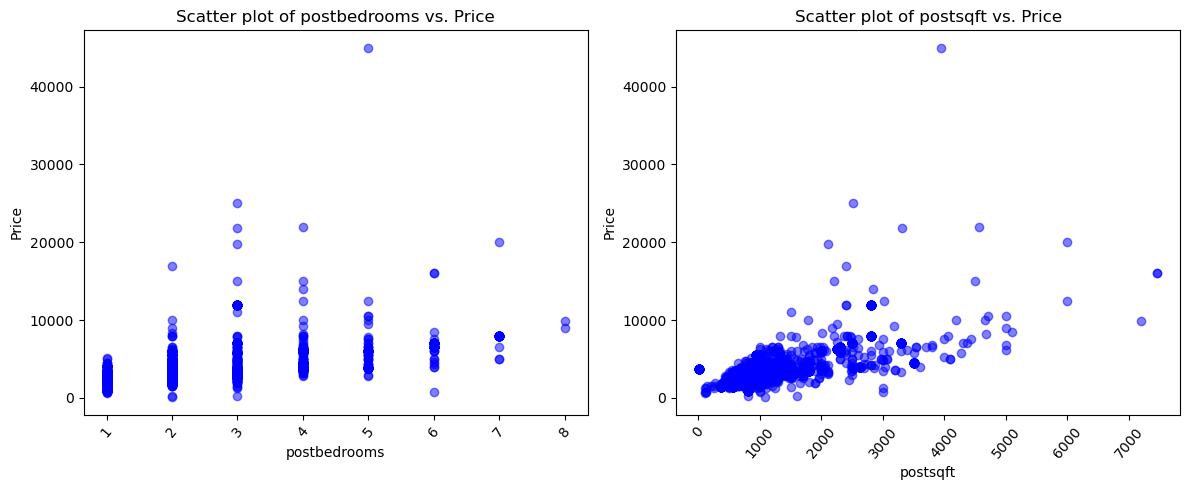

In [29]:
# Select numerical columns (excluding target variable)
numerical_cols = ["postbedrooms", "postsqft"]

# Create scatter plots
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    plt.scatter(df[col], df["Price"], alpha=0.5, color="blue")
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.xticks(rotation=50)
    plt.title(f"Scatter plot of {col} vs. Price")

plt.tight_layout()
plt.show()

### Observations:
*Bedrooms and Price*
- Most listings are clustered at 1 to 3 bedrooms, meaning smaller places dominate the dataset.
- There are some extreme high prices, especially for 3-5 bedrooms.
- The spread of prices varies a lot for the same bedroom count (e.g., some 3-bedroom places are very cheap, while others are super expensive).
- Outliers: Some unreasonably high prices (e.g., over $40,000) might be typos or luxury listings.

Size and Price*
- The trend is more linear: Larger places generally cost more.
- Most listings are under ~2,000 sqft, with many concentrated around small apartments (under 1,000 sqft).
- There are expensive small apartments, possibly luxury condos or listings with incorrect data.

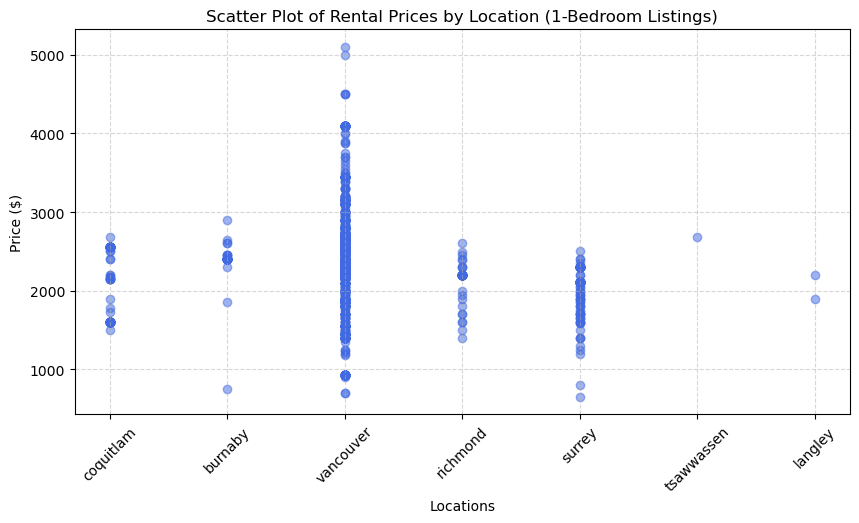

In [31]:
# Filter the dataset to include only 1-bedroom listings
df_1bed = df[df["postbedrooms"] == 1]

# Create scatter plot
plt.figure(figsize=(10,5))
plt.scatter(df_1bed["location"], df_1bed["Price"], alpha=0.5, color="royalblue")

# Labels and title
plt.xlabel("Locations")
plt.ylabel("Price ($)")
plt.title("Scatter Plot of Rental Prices by Location (1-Bedroom Listings)")
plt.xticks(rotation=45)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

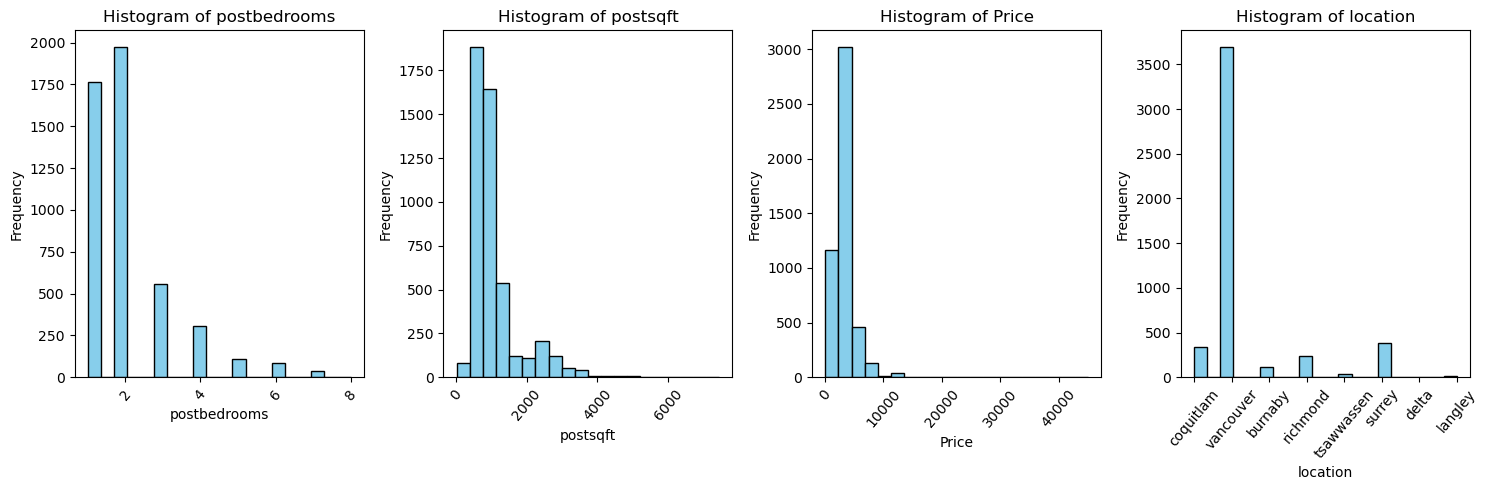

In [26]:
columns = ['postbedrooms', 'postsqft', 'Price', 'location']

# plotting area
plt.figure(figsize=(15, 5))

# loop through the selected columns and creating a histogram
for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)
    counts, bins, patches = plt.hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

## Encoding Categorical Features
Encoding consist in making a "category" column a numeric column to start the ml model.

In [15]:
# Taking a copy of the cleaned dataset. 
df_ml = df.copy()

# Drop the columns that are not important for the ml model.
df_ml = df_ml.drop(['Image', 'Title_URL', 'Label', 'meta'], axis=1)
df_ml.columns

Index(['postbedrooms', 'postsqft', 'Price', 'location'], dtype='object')

In [16]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'zone_name' column
df_ml['location_encoded'] = label_encoder.fit_transform(df_ml['location'])
df_ml = df_ml.drop(columns=['location'])
df_ml.head(2)

,postbedrooms,postsqft,Price,location_encoded
2,4.0,1250.0,3600.0,1
3,3.0,1250.0,3600.0,1


### Comments
The application of Label Encoding is justified as there are values like Vancouver that because is the biggest city has more demand than other cities nearby such as Burnaby, Coquitlam and such.

## Feature Scaling

In [17]:
# Define feature matrix and target variable
X = df_ml[["postbedrooms", "postsqft", "location_encoded"]]
y = df_ml["Price"]

#### Initial train test with 20% for testing

In [19]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_size=0.2 means 80% of the data will be used for training and 20% for testing.

In [20]:
# Initialize StandardScaler
scaler = StandardScaler()

scaler = StandardScaler()
X_train[["postbedrooms", "postsqft"]] = scaler.fit_transform(X_train[["postbedrooms", "postsqft"]])
X_test[["postbedrooms", "postsqft"]] = scaler.transform(X_test[["postbedrooms", "postsqft"]])

Chose standart scaling as it ensures all the features contribute equally to the model. 

## Testing Linear Regression

In [35]:
# Instantiate the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1814166.5870724975
R-squared: 0.49630721909742814


## Testing Random Forest Regressor

In [21]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')

Mean Squared Error (Random Forest): 998824.9979292797
R-squared (Random Forest): 0.7226820599458545


### Comments
Random Forest was chosen because it provides high accuracy since it combines the results of multiple decision trees. Since it averages over many trees, it's less prone to overfitting compared to a single decision tree. It works with small and large datasets.

## Trying the model

In [24]:
# Create new data for prediction
new_data = pd.DataFrame({
    "postbedrooms": [2, 2, 2],
    "postsqft": [800, 800, 800],
    "location": ["vancouver", "burnaby", "coquitlam"]
})

# Ensure locations are properly encoded
new_data["location_encoded"] = label_encoder.transform(new_data["location"])

# Apply scaling to numerical features
new_data[["postbedrooms", "postsqft"]] = scaler.transform(new_data[["postbedrooms", "postsqft"]])

# Predict rental prices for new data
predictions = rf_model.predict(new_data[["postbedrooms", "postsqft", "location_encoded"]])

# Display results
evaluation_results = {
    "Random Forest MSE": mse_rf,
    "Random Forest R²": r2_rf,
    "Predicted Rental Prices (Random Forest)": [round(price) for price in predictions]  # Round to 0 decimals
}

evaluation_results

{'Random Forest MSE': 998824.9979292797,
 'Random Forest R²': 0.7226820599458545,
 'Predicted Rental Prices (Random Forest)': [2751, 2173, 2032]}